In [177]:
import mlflow 
import pandas as pd
import numpy as np

run = mlflow.get_run(run_id='54fd92bd2e9a45bfb7db296421c00db7')

In [178]:
def find_train_sources(run):
    
    train_sources = {}

    for param_key in run.data.params:
        if 'arguseyes.train_source' in param_key:
            source_index = param_key.split('.')[2]
            detail = param_key.split('.')[3]

            if not source_index in train_sources:
                train_sources[source_index] = {}

            train_sources[source_index][detail] = run.data.params[param_key]

    return train_sources  

In [179]:
find_train_sources(run)

{'2': {'attributes': "['category_id', 'category_name']",
  'type': 'SourceType.SIDE_DATA',
  'attribute_types': "['int64', 'object']",
  'num_records': '10'},
 '0': {'attribute_types': "['object', 'int64']",
  'attributes': "['image', 'category_id']",
  'num_records': '4800',
  'type': 'SourceType.ENTITIES'}}

In [180]:
side_input_operator_id = 2
side_input_path = f'{run.info.artifact_uri}/arguseyes-dagnode-{side_input_operator_id}-lineage-df.parquet'
side_input = pd.read_parquet(side_input_path)
side_input[['category_id', 'category_name']]

,category_id,category_name
0,0,T-shirt/top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


In [181]:
input_with_shapley_values_path = f'{run.info.artifact_uri}/{run.data.tags["arguseyes.data_valuation.data_file"]}'
valued_input = pd.read_parquet(input_with_shapley_values_path)

In [182]:
valued_input_with_categories = valued_input.merge(side_input, on='category_id')

In [183]:
def plot_worst_shapley(worst_images):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, len(worst_images))


    for index, axis in enumerate(ax):
        category = worst_images.iloc[index].category_name  
        value = worst_images.iloc[index]['__arguseyes__shapley_value']
        axis.imshow(worst_images.iloc[index].image.reshape(28, 28, 1), cmap='gray')
        axis.set_title(f'{category}\n{value:.5f}')
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)


    plt.tight_layout()    
    fig.set_size_inches(6, 4)
    plt.show()

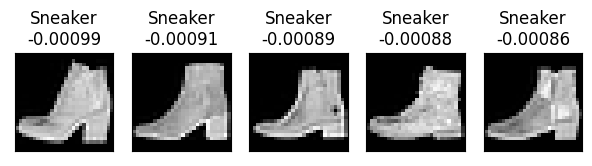

In [184]:
sneakers = valued_input_with_categories[valued_input_with_categories.category_name=='Sneaker']
worst_sneakers = sneakers.sort_values(by=['__arguseyes__shapley_value'])[:5]
plot_worst_shapley(worst_sneakers)

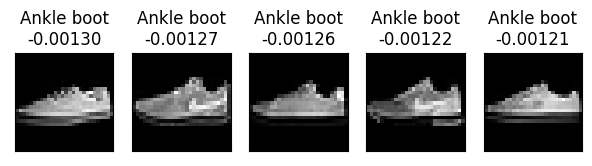

In [185]:
ankleboots = valued_input_with_categories[valued_input_with_categories.category_name=='Ankle boot']
worst_ankleboots = ankleboots.sort_values(by=['__arguseyes__shapley_value'])[:5]
plot_worst_shapley(worst_ankleboots)